In [6]:
import torch
import torch.nn as nn

In [8]:
# This UNET implementation is a modified version of code written by Muhammad Firmansyah Kasim. 
# The original code can be found at https://github.com/mfkasim1/score-based-tutorial/blob/main/03-SGM-with-SDE-MNIST.ipynb

# MIT License

# Copyright (c) 2022 Muhammad Firmansyah Kasim

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import torch

class Unet(torch.nn.Module):
    """
    A simple U-Net architecture for MNIST that takes an input image and time
    """
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

Device: cuda:0


Training:   1%|          | 234/23500 [00:05<09:20, 41.53it/s, epoch=1/100, loss=⠀      0.2459, lr=9.77E-04]

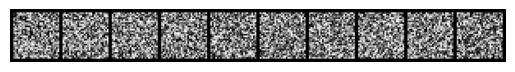

Training:   2%|▏         | 469/23500 [00:12<09:18, 41.23it/s, epoch=2/100, loss=⠀      0.1528, lr=9.54E-04]

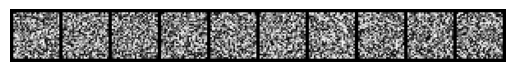

Training:   3%|▎         | 704/23500 [00:17<09:03, 41.91it/s, epoch=3/100, loss=⠀      0.1301, lr=9.32E-04]

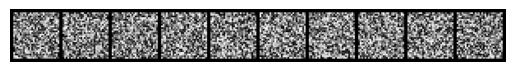

Training:   4%|▍         | 939/23500 [00:24<09:08, 41.12it/s, epoch=4/100, loss=⠀      0.1175, lr=9.10E-04]

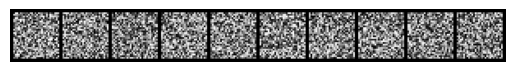

Training:   5%|▍         | 1174/23500 [00:30<08:54, 41.77it/s, epoch=5/100, loss=⠀      0.0962, lr=8.89E-04]

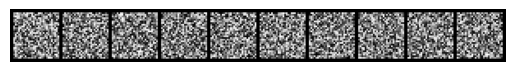

Training:   6%|▌         | 1409/23500 [00:36<08:55, 41.24it/s, epoch=6/100, loss=⠀      0.0750, lr=8.68E-04]

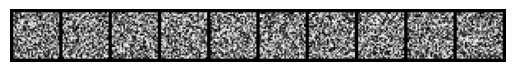

Training:   7%|▋         | 1644/23500 [00:42<08:48, 41.39it/s, epoch=7/100, loss=⠀      0.0780, lr=8.48E-04]

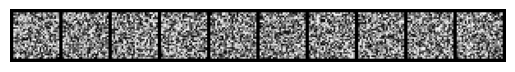

Training:   8%|▊         | 1879/23500 [00:48<08:45, 41.14it/s, epoch=8/100, loss=⠀      0.1040, lr=8.29E-04]

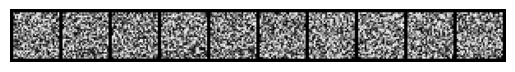

Training:   9%|▉         | 2114/23500 [00:54<08:29, 41.93it/s, epoch=9/100, loss=⠀      0.0678, lr=8.09E-04]

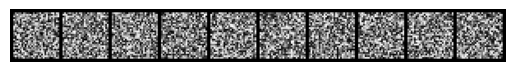

Training:  10%|▉         | 2349/23500 [01:01<08:32, 41.26it/s, epoch=10/100, loss=⠀      0.0738, lr=7.91E-04]

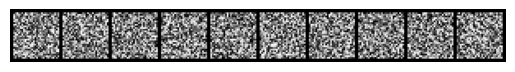

Training:  11%|█         | 2584/23500 [01:07<08:19, 41.89it/s, epoch=11/100, loss=⠀      0.0834, lr=7.72E-04]

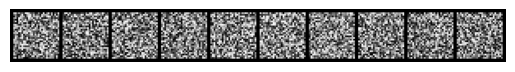

Training:  12%|█▏        | 2819/23500 [01:13<08:18, 41.46it/s, epoch=12/100, loss=⠀      0.0684, lr=7.54E-04]

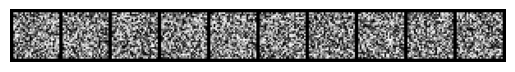

Training:  13%|█▎        | 3054/23500 [01:19<08:09, 41.73it/s, epoch=13/100, loss=⠀      0.0585, lr=7.37E-04]

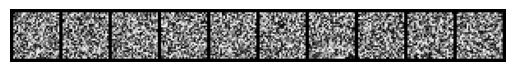

Training:  14%|█▍        | 3290/23500 [01:26<08:02, 41.86it/s, epoch=14/100, loss=⠀      0.0627, lr=7.20E-04]

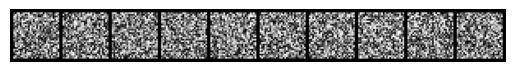

Training:  15%|█▌        | 3525/23500 [01:32<07:54, 42.08it/s, epoch=15/100, loss=⠀      0.0661, lr=7.03E-04]

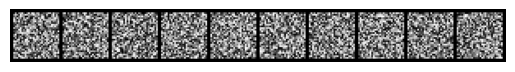

Training:  16%|█▌        | 3759/23500 [01:38<07:59, 41.13it/s, epoch=16/100, loss=⠀      0.0690, lr=6.87E-04]

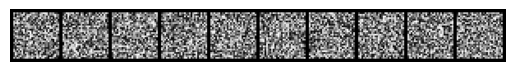

Training:  17%|█▋        | 3994/23500 [01:44<07:58, 40.78it/s, epoch=17/100, loss=⠀      0.0830, lr=6.71E-04]

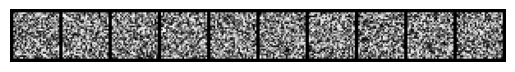

Training:  18%|█▊        | 4229/23500 [01:50<07:51, 40.89it/s, epoch=18/100, loss=⠀      0.0533, lr=6.55E-04]

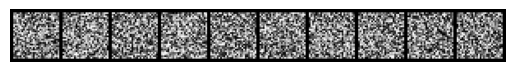

Training:  19%|█▉        | 4464/23500 [01:56<07:41, 41.26it/s, epoch=19/100, loss=⠀      0.0546, lr=6.40E-04]

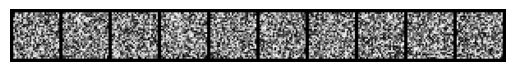

Training:  20%|█▉        | 4699/23500 [02:03<07:39, 40.88it/s, epoch=20/100, loss=⠀      0.0716, lr=6.25E-04]

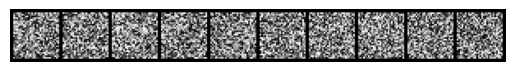

Training:  21%|██        | 4934/23500 [02:09<07:32, 41.04it/s, epoch=21/100, loss=⠀      0.0563, lr=6.10E-04]

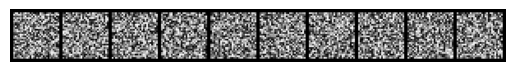

Training:  22%|██▏       | 5169/23500 [02:15<07:26, 41.08it/s, epoch=22/100, loss=⠀      0.0584, lr=5.96E-04]

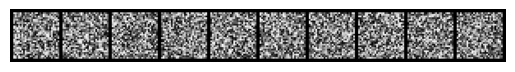

Training:  23%|██▎       | 5404/23500 [02:21<07:12, 41.84it/s, epoch=23/100, loss=⠀      0.0617, lr=5.82E-04]

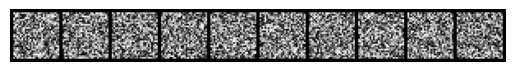

Training:  24%|██▍       | 5639/23500 [02:27<07:12, 41.34it/s, epoch=24/100, loss=⠀      0.0623, lr=5.69E-04]

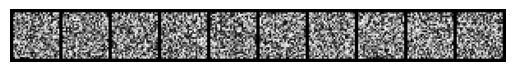

Training:  25%|██▍       | 5874/23500 [02:33<07:37, 38.50it/s, epoch=25/100, loss=⠀      0.0712, lr=5.56E-04]

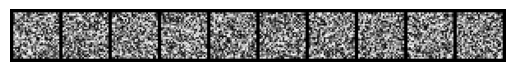

Training:  26%|██▌       | 6109/23500 [02:40<07:01, 41.25it/s, epoch=26/100, loss=⠀      0.0609, lr=5.43E-04]

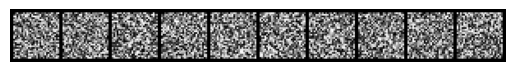

Training:  27%|██▋       | 6344/23500 [02:46<06:51, 41.72it/s, epoch=27/100, loss=⠀      0.0632, lr=5.30E-04]

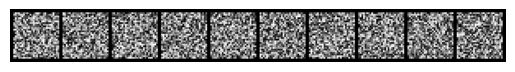

Training:  28%|██▊       | 6579/23500 [02:52<06:48, 41.39it/s, epoch=28/100, loss=⠀      0.0603, lr=5.18E-04]

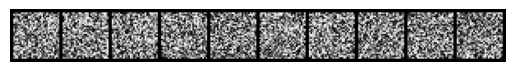

Training:  29%|██▉       | 6814/23500 [02:58<06:42, 41.45it/s, epoch=29/100, loss=⠀      0.0582, lr=5.06E-04]

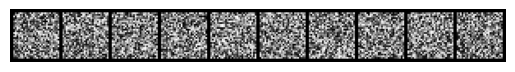

Training:  30%|██▉       | 7049/23500 [03:04<06:38, 41.29it/s, epoch=30/100, loss=⠀      0.0625, lr=4.94E-04]

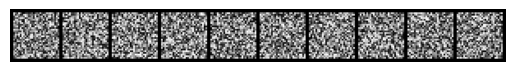

Training:  31%|███       | 7284/23500 [03:10<06:26, 42.00it/s, epoch=31/100, loss=⠀      0.0531, lr=4.83E-04]

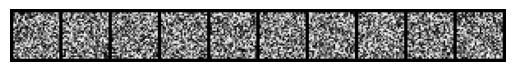

Training:  32%|███▏      | 7519/23500 [03:17<06:29, 41.07it/s, epoch=32/100, loss=⠀      0.0607, lr=4.71E-04]

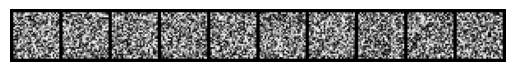

Training:  33%|███▎      | 7754/23500 [03:23<06:18, 41.58it/s, epoch=33/100, loss=⠀      0.0559, lr=4.60E-04]

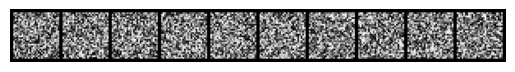

Training:  34%|███▍      | 7989/23500 [03:29<06:20, 40.82it/s, epoch=34/100, loss=⠀      0.0655, lr=4.50E-04]

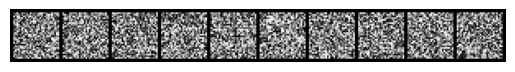

Training:  35%|███▍      | 8224/23500 [03:35<06:07, 41.51it/s, epoch=35/100, loss=⠀      0.0616, lr=4.39E-04]

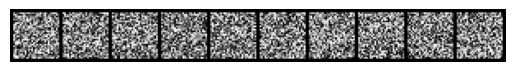

Training:  36%|███▌      | 8459/23500 [03:42<06:05, 41.20it/s, epoch=36/100, loss=⠀      0.0622, lr=4.29E-04]

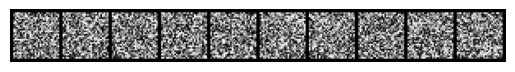

Training:  37%|███▋      | 8694/23500 [03:48<05:53, 41.88it/s, epoch=37/100, loss=⠀      0.0641, lr=4.19E-04]

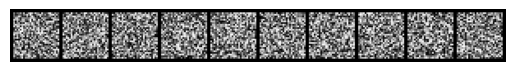

Training:  38%|███▊      | 8929/23500 [03:54<05:50, 41.55it/s, epoch=38/100, loss=⠀      0.0474, lr=4.09E-04]

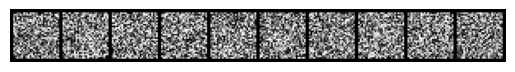

Training:  39%|███▉      | 9164/23500 [04:00<05:47, 41.22it/s, epoch=39/100, loss=⠀      0.0554, lr=4.00E-04]

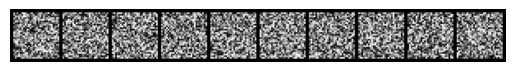

Training:  40%|███▉      | 9399/23500 [04:06<05:40, 41.35it/s, epoch=40/100, loss=⠀      0.0628, lr=3.91E-04]

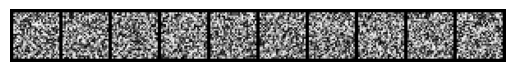

Training:  41%|████      | 9635/23500 [04:12<05:26, 42.52it/s, epoch=41/100, loss=⠀      0.0575, lr=3.82E-04]

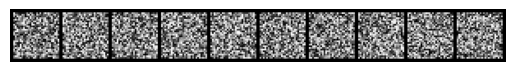

Training:  42%|████▏     | 9870/23500 [04:18<05:24, 42.06it/s, epoch=42/100, loss=⠀      0.0530, lr=3.73E-04]

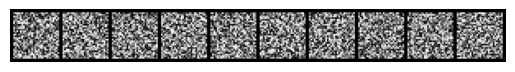

Training:  43%|████▎     | 10105/23500 [04:25<05:16, 42.39it/s, epoch=43/100, loss=⠀      0.0542, lr=3.64E-04]

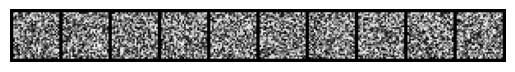

Training:  44%|████▍     | 10340/23500 [04:31<05:12, 42.07it/s, epoch=44/100, loss=⠀      0.0536, lr=3.56E-04]

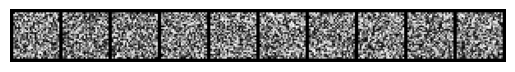

Training:  45%|████▌     | 10575/23500 [04:37<05:01, 42.86it/s, epoch=45/100, loss=⠀      0.0538, lr=3.47E-04]

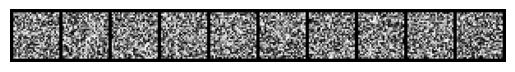

Training:  46%|████▌     | 10810/23500 [04:43<05:01, 42.04it/s, epoch=46/100, loss=⠀      0.0573, lr=3.39E-04]

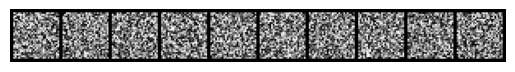

Training:  47%|████▋     | 11045/23500 [04:49<04:53, 42.44it/s, epoch=47/100, loss=⠀      0.0464, lr=3.31E-04]

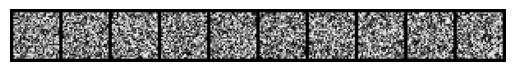

Training:  48%|████▊     | 11280/23500 [04:56<04:51, 41.86it/s, epoch=48/100, loss=⠀      0.0531, lr=3.24E-04]

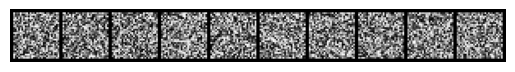

Training:  49%|████▉     | 11515/23500 [05:02<04:43, 42.34it/s, epoch=49/100, loss=⠀      0.0602, lr=3.16E-04]

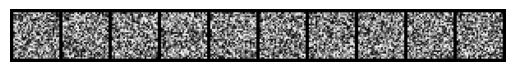

Training:  50%|█████     | 11750/23500 [05:08<04:46, 41.04it/s, epoch=50/100, loss=⠀      0.0513, lr=3.09E-04]

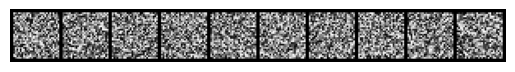

Training:  51%|█████     | 11985/23500 [05:14<04:32, 42.23it/s, epoch=51/100, loss=⠀      0.0480, lr=3.02E-04]

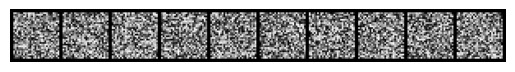

Training:  52%|█████▏    | 12220/23500 [05:20<04:28, 41.97it/s, epoch=52/100, loss=⠀      0.0448, lr=2.95E-04]

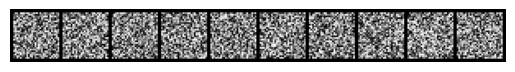

Training:  53%|█████▎    | 12455/23500 [05:26<04:19, 42.49it/s, epoch=53/100, loss=⠀      0.0515, lr=2.88E-04]

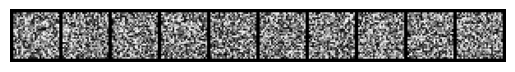

Training:  54%|█████▍    | 12690/23500 [05:33<04:15, 42.30it/s, epoch=54/100, loss=⠀      0.0580, lr=2.81E-04]

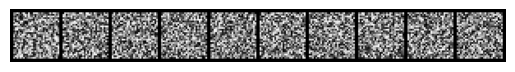

Training:  55%|█████▌    | 12925/23500 [05:39<04:11, 42.10it/s, epoch=55/100, loss=⠀      0.0581, lr=2.75E-04]

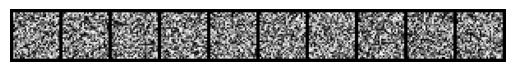

Training:  56%|█████▌    | 13160/23500 [05:45<04:08, 41.62it/s, epoch=56/100, loss=⠀      0.0495, lr=2.68E-04]

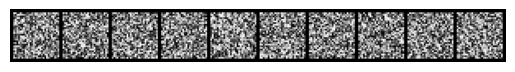

Training:  57%|█████▋    | 13394/23500 [05:51<04:01, 41.84it/s, epoch=57/100, loss=⠀      0.0489, lr=2.62E-04]

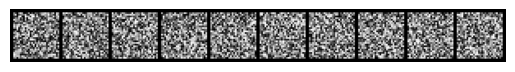

Training:  58%|█████▊    | 13629/23500 [05:58<03:59, 41.27it/s, epoch=58/100, loss=⠀      0.0525, lr=2.56E-04]

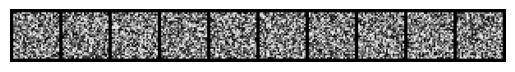

Training:  59%|█████▉    | 13864/23500 [06:03<03:51, 41.54it/s, epoch=59/100, loss=⠀      0.0587, lr=2.50E-04]

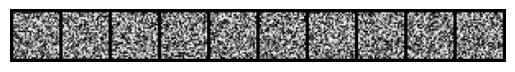

Training:  60%|█████▉    | 14099/23500 [06:10<03:47, 41.37it/s, epoch=60/100, loss=⠀      0.0564, lr=2.44E-04]

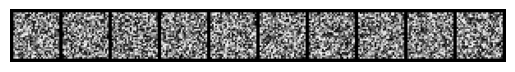

Training:  61%|██████    | 14334/23500 [06:16<03:41, 41.41it/s, epoch=61/100, loss=⠀      0.0484, lr=2.38E-04]

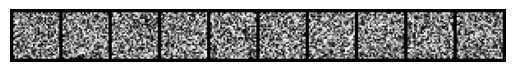

Training:  62%|██████▏   | 14569/23500 [06:22<03:37, 40.99it/s, epoch=62/100, loss=⠀      0.0521, lr=2.33E-04]

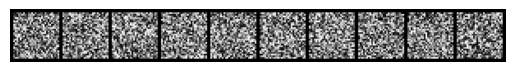

Training:  63%|██████▎   | 14804/23500 [06:28<03:28, 41.62it/s, epoch=63/100, loss=⠀      0.0446, lr=2.28E-04]

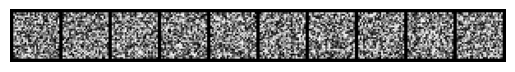

Training:  64%|██████▍   | 15039/23500 [06:34<03:25, 41.20it/s, epoch=64/100, loss=⠀      0.0510, lr=2.22E-04]

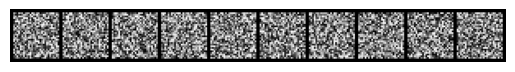

Training:  65%|██████▍   | 15274/23500 [06:41<03:21, 40.92it/s, epoch=65/100, loss=⠀      0.0481, lr=2.17E-04]

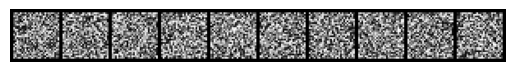

Training:  66%|██████▌   | 15510/23500 [06:47<03:08, 42.33it/s, epoch=66/100, loss=⠀      0.0554, lr=2.12E-04]

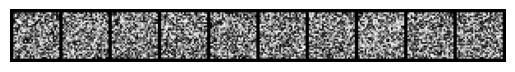

Training:  67%|██████▋   | 15745/23500 [06:53<03:03, 42.17it/s, epoch=67/100, loss=⠀      0.0452, lr=2.07E-04]

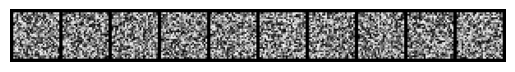

Training:  68%|██████▊   | 15980/23500 [06:59<02:58, 42.12it/s, epoch=68/100, loss=⠀      0.0544, lr=2.02E-04]

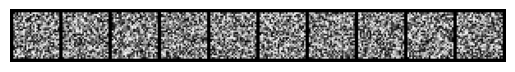

Training:  69%|██████▉   | 16214/23500 [07:05<02:59, 40.53it/s, epoch=69/100, loss=⠀      0.0498, lr=1.98E-04]

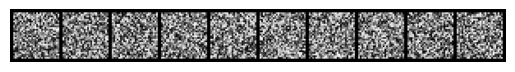

Training:  70%|██████▉   | 16449/23500 [07:12<02:55, 40.28it/s, epoch=70/100, loss=⠀      0.0456, lr=1.93E-04]

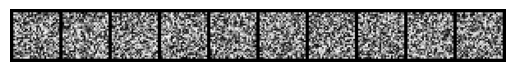

Training:  71%|███████   | 16684/23500 [07:17<02:18, 49.08it/s, epoch=71/100, loss=⠀      0.0531, lr=1.89E-04]

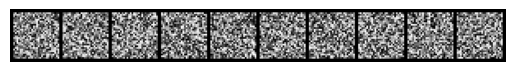

Training:  72%|███████▏  | 16919/23500 [07:22<01:52, 58.66it/s, epoch=72/100, loss=⠀      0.0451, lr=1.84E-04]

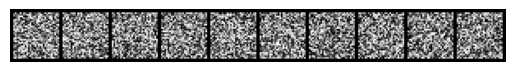

Training:  73%|███████▎  | 17154/23500 [07:26<01:48, 58.65it/s, epoch=73/100, loss=⠀      0.0480, lr=1.80E-04]

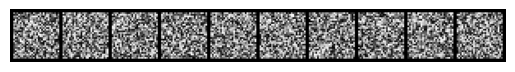

Training:  74%|███████▍  | 17389/23500 [07:30<01:43, 58.79it/s, epoch=74/100, loss=⠀      0.0578, lr=1.76E-04]

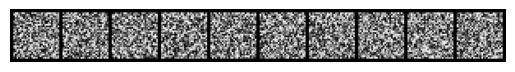

Training:  75%|███████▍  | 17624/23500 [07:34<01:41, 58.16it/s, epoch=75/100, loss=⠀      0.0556, lr=1.72E-04]

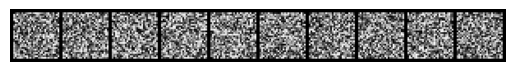

Training:  76%|███████▌  | 17859/23500 [07:38<01:36, 58.70it/s, epoch=76/100, loss=⠀      0.0488, lr=1.68E-04]

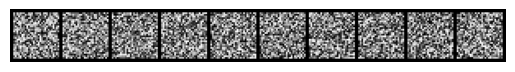

Training:  77%|███████▋  | 18094/23500 [07:42<01:31, 58.95it/s, epoch=77/100, loss=⠀      0.0508, lr=1.64E-04]

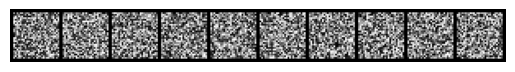

Training:  78%|███████▊  | 18329/23500 [07:46<01:28, 58.65it/s, epoch=78/100, loss=⠀      0.0530, lr=1.60E-04]

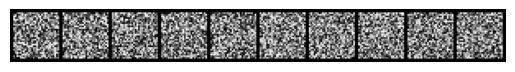

Training:  79%|███████▉  | 18564/23500 [07:50<01:24, 58.53it/s, epoch=79/100, loss=⠀      0.0530, lr=1.56E-04]

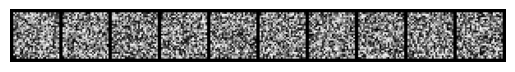

Training:  80%|███████▉  | 18799/23500 [07:54<01:19, 58.81it/s, epoch=80/100, loss=⠀      0.0525, lr=1.53E-04]

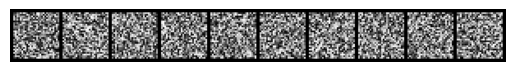

Training:  81%|████████  | 19034/23500 [07:58<01:16, 58.63it/s, epoch=81/100, loss=⠀      0.0535, lr=1.49E-04]

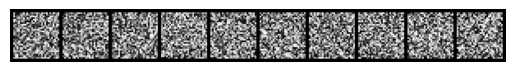

Training:  82%|████████▏ | 19269/23500 [08:02<01:13, 57.69it/s, epoch=82/100, loss=⠀      0.0539, lr=1.46E-04]

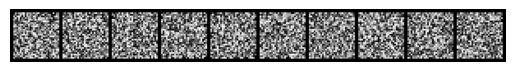

Training:  83%|████████▎ | 19504/23500 [08:06<01:08, 58.72it/s, epoch=83/100, loss=⠀      0.0545, lr=1.42E-04]

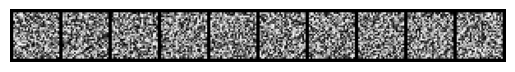

Training:  84%|████████▍ | 19739/23500 [08:10<01:04, 58.67it/s, epoch=84/100, loss=⠀      0.0511, lr=1.39E-04]

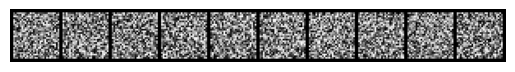

Training:  85%|████████▍ | 19974/23500 [08:14<00:59, 59.05it/s, epoch=85/100, loss=⠀      0.0512, lr=1.36E-04]

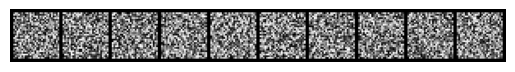

Training:  86%|████████▌ | 20209/23500 [08:18<00:56, 58.60it/s, epoch=86/100, loss=⠀      0.0557, lr=1.33E-04]

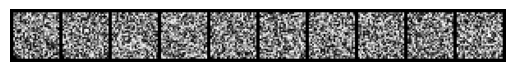

Training:  87%|████████▋ | 20444/23500 [08:22<00:51, 59.73it/s, epoch=87/100, loss=⠀      0.0484, lr=1.29E-04]

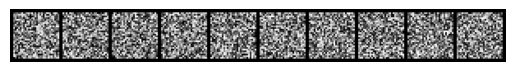

Training:  88%|████████▊ | 20679/23500 [08:26<00:47, 58.87it/s, epoch=88/100, loss=⠀      0.0563, lr=1.26E-04]

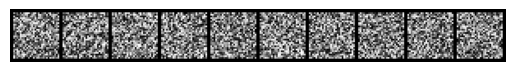

Training:  89%|████████▉ | 20914/23500 [08:31<00:44, 57.78it/s, epoch=89/100, loss=⠀      0.0522, lr=1.23E-04]

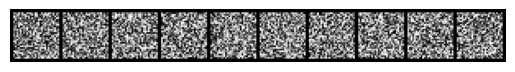

Training:  90%|████████▉ | 21149/23500 [08:35<00:39, 58.91it/s, epoch=90/100, loss=⠀      0.0461, lr=1.21E-04]

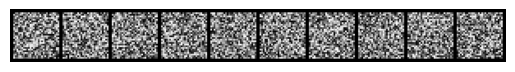

Training:  91%|█████████ | 21384/23500 [08:39<00:35, 58.83it/s, epoch=91/100, loss=⠀      0.0581, lr=1.18E-04]

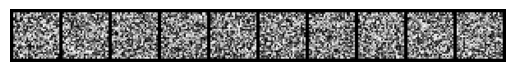

Training:  92%|█████████▏| 21619/23500 [08:43<00:31, 59.02it/s, epoch=92/100, loss=⠀      0.0509, lr=1.15E-04]

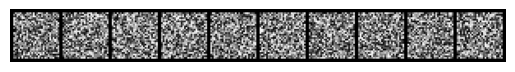

Training:  93%|█████████▎| 21854/23500 [08:47<00:28, 58.76it/s, epoch=93/100, loss=⠀      0.0448, lr=1.12E-04]

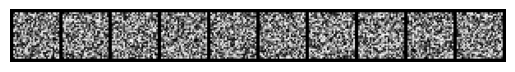

Training:  94%|█████████▍| 22089/23500 [08:51<00:23, 58.89it/s, epoch=94/100, loss=⠀      0.0477, lr=1.10E-04]

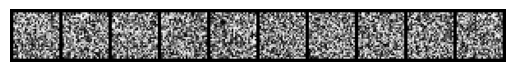

Training:  95%|█████████▍| 22324/23500 [08:55<00:20, 58.71it/s, epoch=95/100, loss=⠀      0.0543, lr=1.07E-04]

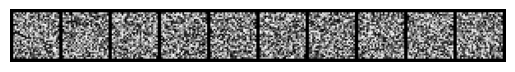

Training:  96%|█████████▌| 22559/23500 [08:59<00:16, 57.96it/s, epoch=96/100, loss=⠀      0.0536, lr=1.05E-04]

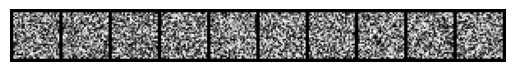

Training:  97%|█████████▋| 22794/23500 [09:03<00:11, 59.20it/s, epoch=97/100, loss=⠀      0.0501, lr=1.02E-04]

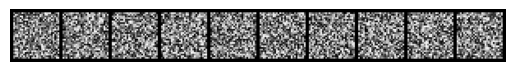

Training:  98%|█████████▊| 23029/23500 [09:07<00:07, 59.64it/s, epoch=98/100, loss=⠀      0.0553, lr=9.99E-05]

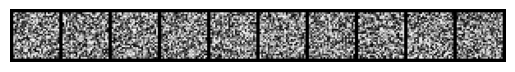

Training:  99%|█████████▉| 23264/23500 [09:11<00:03, 59.88it/s, epoch=99/100, loss=⠀      0.0512, lr=9.76E-05]

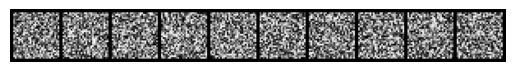

Training: 100%|█████████▉| 23499/23500 [09:15<00:00, 59.68it/s, epoch=100/100, loss=⠀      0.0471, lr=9.54E-05]

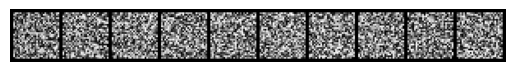

Training: 100%|██████████| 23500/23500 [09:15<00:00, 42.31it/s, epoch=100/100, loss=⠀      0.0471, lr=9.54E-05]


In [ ]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        self._network = network
        self.network = lambda x, t: (self._network(x, t/T))

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        # TODO: Define the mean and std variables
        
        # Mean and standard deviation of q(x_t | x_0)
        mean = torch.sqrt(self.alpha_bar[t]) * x0  # sqrt(alpha_bar_t) * x0
        std = torch.sqrt(1 - self.alpha_bar[t])  # sqrt(1 - alpha_bar_t)
        
        return mean + std*epsilon # q(x_t | x_0)~N(sqrt(alpha_bar_t)*x_0, 1-alpha_bar_t)

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        # TODO: Define the mean and std variables 
        # equation 11 in Ho et al 2020 
        
        # Get beta_t, alpha_t, and alpha_bar_t
        beta_t = self.beta[t]
        alpha_t = self.alpha[t]
        alpha_bar_t = self.alpha_bar[t]
        
        # mean
        mean = (1 / torch.sqrt(alpha_t)) * (xt - (beta_t / torch.sqrt(1 - alpha_bar_t)) * epsilon)
        
        # variance
        variance = beta_t  #  sigma^2=beta_t for simplicity
        
        # noise
        z = epsilon if t[0].item() > 1 else 0  # Noise only added if t > 1

        return mean + torch.sqrt(variance) * z

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        # Predict epsilon using the network
        epsilon_pred = self.network(xt, t)        
        
        loss = -nn.MSELoss(reduction='mean')(epsilon_pred, epsilon) #-nn.MSELoss(reduction='mean')(epsilon_pred, epsilon)
        
        return loss

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        for i, (x, _) in enumerate(dataloader):
            #x, _ = data
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

        
        if per_epoch_callback:
            per_epoch_callback(model)


# Parameters
T = 200
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Construct Unet
mnist_unet = Unet()

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, per_epoch_callback=reporter)
